In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import time
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Blackjack Environment

In [2]:
env_blackjack = gym.make('Blackjack-v1', sab=True, natural=False)
print(f"Blackjack: {env_blackjack.action_space}")

Blackjack: Discrete(2)


### Estimate Blackjack Transitions

In [3]:
P_blackjack = defaultdict(lambda: defaultdict(list))

for _ in range(5000):
    for action in range(env_blackjack.action_space.n):
        state, _ = env_blackjack.reset()
        done = False
        
        while not done:
            next_state, reward, terminated, truncated, _ = env_blackjack.step(action)
            done = terminated or truncated
            P_blackjack[state][action].append((1.0, next_state, reward, done))
            
            if not done:
                state = next_state
            else:
                break

for state in P_blackjack:
    for action in P_blackjack[state]:
        transitions = P_blackjack[state][action]
        if transitions:
            trans_dict = defaultdict(lambda: {'prob': 0, 'reward': 0, 'done': False, 'count': 0})
            for prob, next_state, reward, done in transitions:
                trans_dict[next_state]['prob'] += prob
                trans_dict[next_state]['reward'] += reward
                trans_dict[next_state]['done'] = done
                trans_dict[next_state]['count'] += 1
            
            total_count = sum(t['count'] for t in trans_dict.values())
            P_blackjack[state][action] = [
                (t['count'] / total_count, ns, t['reward'] / t['count'], t['done'])
                for ns, t in trans_dict.items()
            ]

P_blackjack = dict(P_blackjack)
print(f"Estimated transitions for {len(P_blackjack)} states")

Estimated transitions for 279 states


### Value Iteration - Blackjack

In [4]:
states = list(P_blackjack.keys())
n_actions = 2
gamma = 0.99
theta = 1e-10

V_bj_vi = {s: 0 for s in states}
iters_bj_vi = 0
conv_bj_vi = []

start_time = time.time()
for iteration in range(1000):
    delta = 0
    V_new = V_bj_vi.copy()
    
    for state in states:
        if state not in P_blackjack or len(P_blackjack[state]) == 0:
            continue
            
        q_values = []
        for action in range(n_actions):
            if action not in P_blackjack[state]:
                q_values.append(0)
                continue
                
            q_value = 0
            for prob, next_state, reward, done in P_blackjack[state][action]:
                if done:
                    q_value += prob * reward
                else:
                    q_value += prob * (reward + gamma * V_bj_vi.get(next_state, 0))
            q_values.append(q_value)
        
        V_new[state] = max(q_values) if q_values else 0
        delta = max(delta, abs(V_new[state] - V_bj_vi[state]))
    
    V_bj_vi = V_new
    conv_bj_vi.append(delta)
    iters_bj_vi += 1
    
    if delta < theta:
        break

policy_bj_vi = {}
for state in states:
    if state not in P_blackjack or len(P_blackjack[state]) == 0:
        policy_bj_vi[state] = 0
        continue
        
    q_values = []
    for action in range(n_actions):
        if action not in P_blackjack[state]:
            q_values.append(0)
            continue
            
        q_value = 0
        for prob, next_state, reward, done in P_blackjack[state][action]:
            if done:
                q_value += prob * reward
            else:
                q_value += prob * (reward + gamma * V_bj_vi.get(next_state, 0))
        q_values.append(q_value)
    
    policy_bj_vi[state] = np.argmax(q_values) if q_values else 0

time_bj_vi = time.time() - start_time
print(f"VI: {iters_bj_vi} iterations, {time_bj_vi:.2f}s")

VI: 10 iterations, 0.03s


### Policy Iteration - Blackjack

In [5]:
policy_bj_pi = {s: np.random.choice(n_actions) for s in states}
V_bj_pi = {s: 0 for s in states}
iters_bj_pi = 0
conv_bj_pi = []

start_time = time.time()
for iteration in range(1000):
    while True:
        delta = 0
        V_new = V_bj_pi.copy()
        
        for state in states:
            if state not in P_blackjack or len(P_blackjack[state]) == 0:
                continue
            
            action = policy_bj_pi[state]
            if action not in P_blackjack[state]:
                continue
            
            v = 0
            for prob, next_state, reward, done in P_blackjack[state][action]:
                if done:
                    v += prob * reward
                else:
                    v += prob * (reward + gamma * V_bj_pi.get(next_state, 0))
            
            V_new[state] = v
            delta = max(delta, abs(V_new[state] - V_bj_pi[state]))
        
        V_bj_pi = V_new
        if delta < theta:
            break
    
    policy_stable = True
    max_change = 0
    
    for state in states:
        if state not in P_blackjack or len(P_blackjack[state]) == 0:
            continue
        
        old_action = policy_bj_pi[state]
        
        q_values = []
        for action in range(n_actions):
            if action not in P_blackjack[state]:
                q_values.append(0)
                continue
            
            q_value = 0
            for prob, next_state, reward, done in P_blackjack[state][action]:
                if done:
                    q_value += prob * reward
                else:
                    q_value += prob * (reward + gamma * V_bj_pi.get(next_state, 0))
            q_values.append(q_value)
        
        policy_bj_pi[state] = np.argmax(q_values) if q_values else 0
        
        if old_action != policy_bj_pi[state]:
            policy_stable = False
            max_change += 1
    
    conv_bj_pi.append(max_change)
    iters_bj_pi += 1
    
    if policy_stable:
        break

time_bj_pi = time.time() - start_time
print(f"PI: {iters_bj_pi} iterations, {time_bj_pi:.2f}s")

PI: 4 iterations, 0.03s


### SARSA - Blackjack

In [6]:
Q_bj_sarsa = defaultdict(lambda: np.zeros(env_blackjack.action_space.n))
epsilon = 1.0
epsilon_end = 0.01
epsilon_decay = 0.9995
alpha = 0.1
rewards_bj_sarsa = []
lengths_bj_sarsa = []

start_time = time.time()
for episode in range(50000):
    state, _ = env_blackjack.reset()
    action = np.random.choice(env_blackjack.action_space.n) if np.random.random() < epsilon else np.argmax(Q_bj_sarsa[state])
    
    episode_reward = 0
    episode_length = 0
    done = False
    
    while not done:
        next_state, reward, terminated, truncated, _ = env_blackjack.step(action)
        done = terminated or truncated
        
        next_action = np.random.choice(env_blackjack.action_space.n) if np.random.random() < epsilon else np.argmax(Q_bj_sarsa[next_state])
        
        td_target = reward + gamma * Q_bj_sarsa[next_state][next_action] * (not done)
        td_error = td_target - Q_bj_sarsa[state][action]
        Q_bj_sarsa[state][action] += alpha * td_error
        
        state = next_state
        action = next_action
        episode_reward += reward
        episode_length += 1
    
    epsilon = max(epsilon_end, epsilon * epsilon_decay)
    rewards_bj_sarsa.append(episode_reward)
    lengths_bj_sarsa.append(episode_length)

policy_bj_sarsa = {state: np.argmax(Q_bj_sarsa[state]) for state in Q_bj_sarsa}
time_bj_sarsa = time.time() - start_time
print(f"SARSA: {time_bj_sarsa:.2f}s")

SARSA: 5.91s


### Q-Learning - Blackjack

In [7]:
Q_bj_qlearn = defaultdict(lambda: np.zeros(env_blackjack.action_space.n))
epsilon = 1.0
rewards_bj_qlearn = []
lengths_bj_qlearn = []

start_time = time.time()
for episode in range(50000):
    state, _ = env_blackjack.reset()
    episode_reward = 0
    episode_length = 0
    done = False
    
    while not done:
        action = np.random.choice(env_blackjack.action_space.n) if np.random.random() < epsilon else np.argmax(Q_bj_qlearn[state])
        next_state, reward, terminated, truncated, _ = env_blackjack.step(action)
        done = terminated or truncated
        
        td_target = reward + gamma * np.max(Q_bj_qlearn[next_state]) * (not done)
        td_error = td_target - Q_bj_qlearn[state][action]
        Q_bj_qlearn[state][action] += alpha * td_error
        
        state = next_state
        episode_reward += reward
        episode_length += 1
    
    epsilon = max(epsilon_end, epsilon * epsilon_decay)
    rewards_bj_qlearn.append(episode_reward)
    lengths_bj_qlearn.append(episode_length)

policy_bj_qlearn = {state: np.argmax(Q_bj_qlearn[state]) for state in Q_bj_qlearn}
time_bj_qlearn = time.time() - start_time
print(f"Q-Learning: {time_bj_qlearn:.2f}s")

Q-Learning: 6.09s


### Evaluate Blackjack Policies

In [8]:
print("\n=== Blackjack Evaluation ===")

total_rewards = []
for _ in range(1000):
    state, _ = env_blackjack.reset()
    episode_reward = 0
    done = False
    while not done:
        action = policy_bj_vi.get(state, 0)
        state, reward, terminated, truncated, _ = env_blackjack.step(action)
        done = terminated or truncated
        episode_reward += reward
    total_rewards.append(episode_reward)
mean_vi, std_vi = np.mean(total_rewards), np.std(total_rewards)

total_rewards = []
for _ in range(1000):
    state, _ = env_blackjack.reset()
    episode_reward = 0
    done = False
    while not done:
        action = policy_bj_pi.get(state, 0)
        state, reward, terminated, truncated, _ = env_blackjack.step(action)
        done = terminated or truncated
        episode_reward += reward
    total_rewards.append(episode_reward)
mean_pi, std_pi = np.mean(total_rewards), np.std(total_rewards)

total_rewards = []
for _ in range(1000):
    state, _ = env_blackjack.reset()
    episode_reward = 0
    done = False
    while not done:
        action = policy_bj_sarsa.get(state, 0)
        state, reward, terminated, truncated, _ = env_blackjack.step(action)
        done = terminated or truncated
        episode_reward += reward
    total_rewards.append(episode_reward)
mean_sarsa, std_sarsa = np.mean(total_rewards), np.std(total_rewards)

total_rewards = []
for _ in range(1000):
    state, _ = env_blackjack.reset()
    episode_reward = 0
    done = False
    while not done:
        action = policy_bj_qlearn.get(state, 0)
        state, reward, terminated, truncated, _ = env_blackjack.step(action)
        done = terminated or truncated
        episode_reward += reward
    total_rewards.append(episode_reward)
mean_qlearn, std_qlearn = np.mean(total_rewards), np.std(total_rewards)

print(f"VI: {mean_vi:.3f} ± {std_vi:.3f}")
print(f"PI: {mean_pi:.3f} ± {std_pi:.3f}")
print(f"SARSA: {mean_sarsa:.3f} ± {std_sarsa:.3f}")
print(f"Q-Learning: {mean_qlearn:.3f} ± {std_qlearn:.3f}")


=== Blackjack Evaluation ===
VI: -0.007 ± 0.959
PI: -0.061 ± 0.956
SARSA: -0.048 ± 0.960
Q-Learning: -0.075 ± 0.947


## CartPole Environment

In [9]:
env_cartpole = gym.make('CartPole-v1')
print(f"CartPole: {env_cartpole.action_space}")

CartPole: Discrete(2)


### State Discretization

In [10]:
n_bins_coarse = [4, 4, 4, 4]
n_bins_medium = [6, 6, 6, 6]

bounds = [[-2.4, 2.4], [-3.0, 3.0], [-0.5, 0.5], [-2.0, 2.0]]
bins_coarse = [np.linspace(bounds[i][0], bounds[i][1], n_bins_coarse[i] - 1) for i in range(4)]
bins_medium = [np.linspace(bounds[i][0], bounds[i][1], n_bins_medium[i] - 1) for i in range(4)]

print(f"Coarse: {np.prod(n_bins_coarse)} states")
print(f"Medium: {np.prod(n_bins_medium)} states")

Coarse: 256 states
Medium: 1296 states


### Build CartPole Transitions - Coarse

In [11]:
P_cartpole_coarse = defaultdict(lambda: defaultdict(list))

for _ in range(3000):
    state, _ = env_cartpole.reset()
    discrete_state = tuple(np.digitize(np.clip(state[i], bounds[i][0], bounds[i][1]), bins_coarse[i]) for i in range(4))
    done = False
    steps = 0
    
    while not done and steps < 500:
        for action in range(env_cartpole.action_space.n):
            next_state, reward, terminated, truncated, _ = env_cartpole.step(action)
            done = terminated or truncated
            discrete_next_state = tuple(np.digitize(np.clip(next_state[i], bounds[i][0], bounds[i][1]), bins_coarse[i]) for i in range(4))
            
            P_cartpole_coarse[discrete_state][action].append((1.0, discrete_next_state, reward, done))
            if done:
                break
            state = next_state
            discrete_state = discrete_next_state
            steps += 1

for state in P_cartpole_coarse:
    for action in P_cartpole_coarse[state]:
        transitions = P_cartpole_coarse[state][action]
        if transitions:
            trans_dict = defaultdict(lambda: {'prob': 0, 'reward': 0, 'done': False, 'count': 0})
            for prob, next_state, reward, done in transitions:
                trans_dict[next_state]['prob'] += prob
                trans_dict[next_state]['reward'] += reward
                trans_dict[next_state]['done'] = done
                trans_dict[next_state]['count'] += 1
            
            total_count = sum(t['count'] for t in trans_dict.values())
            P_cartpole_coarse[state][action] = [
                (t['count'] / total_count, ns, t['reward'] / t['count'], t['done'])
                for ns, t in trans_dict.items()
            ]

P_cartpole_coarse = dict(P_cartpole_coarse)
print(f"Coarse model: {len(P_cartpole_coarse)} states")

Coarse model: 16 states


### Build CartPole Transitions - Medium

In [12]:
P_cartpole_medium = defaultdict(lambda: defaultdict(list))

for _ in range(5000):
    state, _ = env_cartpole.reset()
    discrete_state = tuple(np.digitize(np.clip(state[i], bounds[i][0], bounds[i][1]), bins_medium[i]) for i in range(4))
    done = False
    steps = 0
    
    while not done and steps < 500:
        for action in range(env_cartpole.action_space.n):
            next_state, reward, terminated, truncated, _ = env_cartpole.step(action)
            done = terminated or truncated
            discrete_next_state = tuple(np.digitize(np.clip(next_state[i], bounds[i][0], bounds[i][1]), bins_medium[i]) for i in range(4))
            
            P_cartpole_medium[discrete_state][action].append((1.0, discrete_next_state, reward, done))
            if done:
                break
            state = next_state
            discrete_state = discrete_next_state
            steps += 1

for state in P_cartpole_medium:
    for action in P_cartpole_medium[state]:
        transitions = P_cartpole_medium[state][action]
        if transitions:
            trans_dict = defaultdict(lambda: {'prob': 0, 'reward': 0, 'done': False, 'count': 0})
            for prob, next_state, reward, done in transitions:
                trans_dict[next_state]['prob'] += prob
                trans_dict[next_state]['reward'] += reward
                trans_dict[next_state]['done'] = done
                trans_dict[next_state]['count'] += 1
            
            total_count = sum(t['count'] for t in trans_dict.values())
            P_cartpole_medium[state][action] = [
                (t['count'] / total_count, ns, t['reward'] / t['count'], t['done'])
                for ns, t in trans_dict.items()
            ]

P_cartpole_medium = dict(P_cartpole_medium)
print(f"Medium model: {len(P_cartpole_medium)} states")

Medium model: 16 states


### Value Iteration - CartPole Coarse

In [13]:
states_cp_coarse = list(P_cartpole_coarse.keys())
V_cp_vi_coarse = {s: 0 for s in states_cp_coarse}
iters_cp_vi_coarse = 0
conv_cp_vi_coarse = []

start_time = time.time()
for iteration in range(1000):
    delta = 0
    V_new = V_cp_vi_coarse.copy()
    
    for state in states_cp_coarse:
        if state not in P_cartpole_coarse or len(P_cartpole_coarse[state]) == 0:
            continue
        
        q_values = []
        for action in range(2):
            if action not in P_cartpole_coarse[state]:
                q_values.append(0)
                continue
            
            q_value = 0
            for prob, next_state, reward, done in P_cartpole_coarse[state][action]:
                if done:
                    q_value += prob * reward
                else:
                    q_value += prob * (reward + gamma * V_cp_vi_coarse.get(next_state, 0))
            q_values.append(q_value)
        
        V_new[state] = max(q_values) if q_values else 0
        delta = max(delta, abs(V_new[state] - V_cp_vi_coarse[state]))
    
    V_cp_vi_coarse = V_new
    conv_cp_vi_coarse.append(delta)
    iters_cp_vi_coarse += 1
    
    if delta < theta:
        break

policy_cp_vi_coarse = {}
for state in states_cp_coarse:
    if state not in P_cartpole_coarse or len(P_cartpole_coarse[state]) == 0:
        policy_cp_vi_coarse[state] = 0
        continue
    
    q_values = []
    for action in range(2):
        if action not in P_cartpole_coarse[state]:
            q_values.append(0)
            continue
        
        q_value = 0
        for prob, next_state, reward, done in P_cartpole_coarse[state][action]:
            if done:
                q_value += prob * reward
            else:
                q_value += prob * (reward + gamma * V_cp_vi_coarse.get(next_state, 0))
        q_values.append(q_value)
    
    policy_cp_vi_coarse[state] = np.argmax(q_values) if q_values else 0

time_cp_vi_coarse = time.time() - start_time
print(f"Coarse VI: {iters_cp_vi_coarse} iterations, {time_cp_vi_coarse:.2f}s")

Coarse VI: 1000 iterations, 0.06s


### Policy Iteration - CartPole Coarse

In [14]:
policy_cp_pi_coarse = {s: np.random.choice(2) for s in states_cp_coarse}
V_cp_pi_coarse = {s: 0 for s in states_cp_coarse}
iters_cp_pi_coarse = 0
conv_cp_pi_coarse = []

start_time = time.time()
for iteration in range(1000):
    while True:
        delta = 0
        V_new = V_cp_pi_coarse.copy()
        
        for state in states_cp_coarse:
            if state not in P_cartpole_coarse or len(P_cartpole_coarse[state]) == 0:
                continue
            
            action = policy_cp_pi_coarse[state]
            if action not in P_cartpole_coarse[state]:
                continue
            
            v = 0
            for prob, next_state, reward, done in P_cartpole_coarse[state][action]:
                if done:
                    v += prob * reward
                else:
                    v += prob * (reward + gamma * V_cp_pi_coarse.get(next_state, 0))
            
            V_new[state] = v
            delta = max(delta, abs(V_new[state] - V_cp_pi_coarse[state]))
        
        V_cp_pi_coarse = V_new
        if delta < theta:
            break
    
    policy_stable = True
    max_change = 0
    
    for state in states_cp_coarse:
        if state not in P_cartpole_coarse or len(P_cartpole_coarse[state]) == 0:
            continue
        
        old_action = policy_cp_pi_coarse[state]
        
        q_values = []
        for action in range(2):
            if action not in P_cartpole_coarse[state]:
                q_values.append(0)
                continue
            
            q_value = 0
            for prob, next_state, reward, done in P_cartpole_coarse[state][action]:
                if done:
                    q_value += prob * reward
                else:
                    q_value += prob * (reward + gamma * V_cp_pi_coarse.get(next_state, 0))
            q_values.append(q_value)
        
        policy_cp_pi_coarse[state] = np.argmax(q_values) if q_values else 0
        
        if old_action != policy_cp_pi_coarse[state]:
            policy_stable = False
            max_change += 1
    
    conv_cp_pi_coarse.append(max_change)
    iters_cp_pi_coarse += 1
    
    if policy_stable:
        break

time_cp_pi_coarse = time.time() - start_time
print(f"Coarse PI: {iters_cp_pi_coarse} iterations, {time_cp_pi_coarse:.2f}s")

Coarse PI: 3 iterations, 0.10s


### Value Iteration - CartPole Medium

In [15]:
states_cp_medium = list(P_cartpole_medium.keys())
V_cp_vi_medium = {s: 0 for s in states_cp_medium}
iters_cp_vi_medium = 0
conv_cp_vi_medium = []

start_time = time.time()
for iteration in range(1000):
    delta = 0
    V_new = V_cp_vi_medium.copy()
    
    for state in states_cp_medium:
        if state not in P_cartpole_medium or len(P_cartpole_medium[state]) == 0:
            continue
        
        q_values = []
        for action in range(2):
            if action not in P_cartpole_medium[state]:
                q_values.append(0)
                continue
            
            q_value = 0
            for prob, next_state, reward, done in P_cartpole_medium[state][action]:
                if done:
                    q_value += prob * reward
                else:
                    q_value += prob * (reward + gamma * V_cp_vi_medium.get(next_state, 0))
            q_values.append(q_value)
        
        V_new[state] = max(q_values) if q_values else 0
        delta = max(delta, abs(V_new[state] - V_cp_vi_medium[state]))
    
    V_cp_vi_medium = V_new
    conv_cp_vi_medium.append(delta)
    iters_cp_vi_medium += 1
    
    if delta < theta:
        break

policy_cp_vi_medium = {}
for state in states_cp_medium:
    if state not in P_cartpole_medium or len(P_cartpole_medium[state]) == 0:
        policy_cp_vi_medium[state] = 0
        continue
    
    q_values = []
    for action in range(2):
        if action not in P_cartpole_medium[state]:
            q_values.append(0)
            continue
        
        q_value = 0
        for prob, next_state, reward, done in P_cartpole_medium[state][action]:
            if done:
                q_value += prob * reward
            else:
                q_value += prob * (reward + gamma * V_cp_vi_medium.get(next_state, 0))
        q_values.append(q_value)
    
    policy_cp_vi_medium[state] = np.argmax(q_values) if q_values else 0

time_cp_vi_medium = time.time() - start_time
print(f"Medium VI: {iters_cp_vi_medium} iterations, {time_cp_vi_medium:.2f}s")

Medium VI: 1000 iterations, 0.07s


### Policy Iteration - CartPole Medium

In [16]:
policy_cp_pi_medium = {s: np.random.choice(2) for s in states_cp_medium}
V_cp_pi_medium = {s: 0 for s in states_cp_medium}
iters_cp_pi_medium = 0
conv_cp_pi_medium = []

start_time = time.time()
for iteration in range(1000):
    while True:
        delta = 0
        V_new = V_cp_pi_medium.copy()
        
        for state in states_cp_medium:
            if state not in P_cartpole_medium or len(P_cartpole_medium[state]) == 0:
                continue
            
            action = policy_cp_pi_medium[state]
            if action not in P_cartpole_medium[state]:
                continue
            
            v = 0
            for prob, next_state, reward, done in P_cartpole_medium[state][action]:
                if done:
                    v += prob * reward
                else:
                    v += prob * (reward + gamma * V_cp_pi_medium.get(next_state, 0))
            
            V_new[state] = v
            delta = max(delta, abs(V_new[state] - V_cp_pi_medium[state]))
        
        V_cp_pi_medium = V_new
        if delta < theta:
            break
    
    policy_stable = True
    max_change = 0
    
    for state in states_cp_medium:
        if state not in P_cartpole_medium or len(P_cartpole_medium[state]) == 0:
            continue
        
        old_action = policy_cp_pi_medium[state]
        
        q_values = []
        for action in range(2):
            if action not in P_cartpole_medium[state]:
                q_values.append(0)
                continue
            
            q_value = 0
            for prob, next_state, reward, done in P_cartpole_medium[state][action]:
                if done:
                    q_value += prob * reward
                else:
                    q_value += prob * (reward + gamma * V_cp_pi_medium.get(next_state, 0))
            q_values.append(q_value)
        
        policy_cp_pi_medium[state] = np.argmax(q_values) if q_values else 0
        
        if old_action != policy_cp_pi_medium[state]:
            policy_stable = False
            max_change += 1
    
    conv_cp_pi_medium.append(max_change)
    iters_cp_pi_medium += 1
    
    if policy_stable:
        break

time_cp_pi_medium = time.time() - start_time
print(f"Medium PI: {iters_cp_pi_medium} iterations, {time_cp_pi_medium:.2f}s")

Medium PI: 3 iterations, 0.10s


### SARSA - CartPole

In [17]:
Q_cp_sarsa = defaultdict(lambda: np.zeros(env_cartpole.action_space.n))
epsilon = 1.0
rewards_cp_sarsa = []
lengths_cp_sarsa = []

start_time = time.time()
for episode in range(5000):
    state, _ = env_cartpole.reset()
    discrete_state = tuple(np.digitize(np.clip(state[i], bounds[i][0], bounds[i][1]), bins_medium[i]) for i in range(4))
    action = np.random.choice(env_cartpole.action_space.n) if np.random.random() < epsilon else np.argmax(Q_cp_sarsa[discrete_state])
    
    episode_reward = 0
    episode_length = 0
    done = False
    
    while not done and episode_length < 500:
        next_state, reward, terminated, truncated, _ = env_cartpole.step(action)
        done = terminated or truncated
        discrete_next_state = tuple(np.digitize(np.clip(next_state[i], bounds[i][0], bounds[i][1]), bins_medium[i]) for i in range(4))
        
        next_action = np.random.choice(env_cartpole.action_space.n) if np.random.random() < epsilon else np.argmax(Q_cp_sarsa[discrete_next_state])
        
        td_target = reward + gamma * Q_cp_sarsa[discrete_next_state][next_action] * (not done)
        td_error = td_target - Q_cp_sarsa[discrete_state][action]
        Q_cp_sarsa[discrete_state][action] += alpha * td_error
        
        discrete_state = discrete_next_state
        action = next_action
        episode_reward += reward
        episode_length += 1
    
    epsilon = max(epsilon_end, epsilon * epsilon_decay)
    rewards_cp_sarsa.append(episode_reward)
    lengths_cp_sarsa.append(episode_length)

policy_cp_sarsa = {state: np.argmax(Q_cp_sarsa[state]) for state in Q_cp_sarsa}
time_cp_sarsa = time.time() - start_time
print(f"CartPole SARSA: {time_cp_sarsa:.2f}s")

CartPole SARSA: 23.29s


### Q-Learning - CartPole

In [18]:
Q_cp_qlearn = defaultdict(lambda: np.zeros(env_cartpole.action_space.n))
epsilon = 1.0
rewards_cp_qlearn = []
lengths_cp_qlearn = []

start_time = time.time()
for episode in range(5000):
    state, _ = env_cartpole.reset()
    discrete_state = tuple(np.digitize(np.clip(state[i], bounds[i][0], bounds[i][1]), bins_medium[i]) for i in range(4))
    
    episode_reward = 0
    episode_length = 0
    done = False
    
    while not done and episode_length < 500:
        action = np.random.choice(env_cartpole.action_space.n) if np.random.random() < epsilon else np.argmax(Q_cp_qlearn[discrete_state])
        next_state, reward, terminated, truncated, _ = env_cartpole.step(action)
        done = terminated or truncated
        discrete_next_state = tuple(np.digitize(np.clip(next_state[i], bounds[i][0], bounds[i][1]), bins_medium[i]) for i in range(4))
        
        td_target = reward + gamma * np.max(Q_cp_qlearn[discrete_next_state]) * (not done)
        td_error = td_target - Q_cp_qlearn[discrete_state][action]
        Q_cp_qlearn[discrete_state][action] += alpha * td_error
        
        discrete_state = discrete_next_state
        episode_reward += reward
        episode_length += 1
    
    epsilon = max(epsilon_end, epsilon * epsilon_decay)
    rewards_cp_qlearn.append(episode_reward)
    lengths_cp_qlearn.append(episode_length)

policy_cp_qlearn = {state: np.argmax(Q_cp_qlearn[state]) for state in Q_cp_qlearn}
time_cp_qlearn = time.time() - start_time
print(f"CartPole Q-Learning: {time_cp_qlearn:.2f}s")

CartPole Q-Learning: 24.77s


### Evaluate CartPole Policies

In [19]:
print("\n=== CartPole Evaluation ===")

episode_rewards = []
episode_lengths = []
for _ in range(100):
    state, _ = env_cartpole.reset()
    episode_reward = 0
    episode_length = 0
    done = False
    while not done and episode_length < 500:
        discrete_state = tuple(np.digitize(np.clip(state[i], bounds[i][0], bounds[i][1]), bins_coarse[i]) for i in range(4))
        action = policy_cp_vi_coarse.get(discrete_state, 0)
        state, reward, terminated, truncated, _ = env_cartpole.step(action)
        done = terminated or truncated
        episode_reward += reward
        episode_length += 1
    episode_rewards.append(episode_reward)
    episode_lengths.append(episode_length)
mean_vi_coarse, std_vi_coarse, len_vi_coarse = np.mean(episode_rewards), np.std(episode_rewards), np.mean(episode_lengths)

episode_rewards = []
episode_lengths = []
for _ in range(100):
    state, _ = env_cartpole.reset()
    episode_reward = 0
    episode_length = 0
    done = False
    while not done and episode_length < 500:
        discrete_state = tuple(np.digitize(np.clip(state[i], bounds[i][0], bounds[i][1]), bins_coarse[i]) for i in range(4))
        action = policy_cp_pi_coarse.get(discrete_state, 0)
        state, reward, terminated, truncated, _ = env_cartpole.step(action)
        done = terminated or truncated
        episode_reward += reward
        episode_length += 1
    episode_rewards.append(episode_reward)
    episode_lengths.append(episode_length)
mean_pi_coarse, std_pi_coarse, len_pi_coarse = np.mean(episode_rewards), np.std(episode_rewards), np.mean(episode_lengths)

episode_rewards = []
episode_lengths = []
for _ in range(100):
    state, _ = env_cartpole.reset()
    episode_reward = 0
    episode_length = 0
    done = False
    while not done and episode_length < 500:
        discrete_state = tuple(np.digitize(np.clip(state[i], bounds[i][0], bounds[i][1]), bins_medium[i]) for i in range(4))
        action = policy_cp_vi_medium.get(discrete_state, 0)
        state, reward, terminated, truncated, _ = env_cartpole.step(action)
        done = terminated or truncated
        episode_reward += reward
        episode_length += 1
    episode_rewards.append(episode_reward)
    episode_lengths.append(episode_length)
mean_vi_medium, std_vi_medium, len_vi_medium = np.mean(episode_rewards), np.std(episode_rewards), np.mean(episode_lengths)

episode_rewards = []
episode_lengths = []
for _ in range(100):
    state, _ = env_cartpole.reset()
    episode_reward = 0
    episode_length = 0
    done = False
    while not done and episode_length < 500:
        discrete_state = tuple(np.digitize(np.clip(state[i], bounds[i][0], bounds[i][1]), bins_medium[i]) for i in range(4))
        action = policy_cp_pi_medium.get(discrete_state, 0)
        state, reward, terminated, truncated, _ = env_cartpole.step(action)
        done = terminated or truncated
        episode_reward += reward
        episode_length += 1
    episode_rewards.append(episode_reward)
    episode_lengths.append(episode_length)
mean_pi_medium, std_pi_medium, len_pi_medium = np.mean(episode_rewards), np.std(episode_rewards), np.mean(episode_lengths)

episode_rewards = []
episode_lengths = []
for _ in range(100):
    state, _ = env_cartpole.reset()
    episode_reward = 0
    episode_length = 0
    done = False
    while not done and episode_length < 500:
        discrete_state = tuple(np.digitize(np.clip(state[i], bounds[i][0], bounds[i][1]), bins_medium[i]) for i in range(4))
        action = policy_cp_sarsa.get(discrete_state, 0)
        state, reward, terminated, truncated, _ = env_cartpole.step(action)
        done = terminated or truncated
        episode_reward += reward
        episode_length += 1
    episode_rewards.append(episode_reward)
    episode_lengths.append(episode_length)
mean_sarsa, std_sarsa, len_sarsa = np.mean(episode_rewards), np.std(episode_rewards), np.mean(episode_lengths)

episode_rewards = []
episode_lengths = []
for _ in range(100):
    state, _ = env_cartpole.reset()
    episode_reward = 0
    episode_length = 0
    done = False
    while not done and episode_length < 500:
        discrete_state = tuple(np.digitize(np.clip(state[i], bounds[i][0], bounds[i][1]), bins_medium[i]) for i in range(4))
        action = policy_cp_qlearn.get(discrete_state, 0)
        state, reward, terminated, truncated, _ = env_cartpole.step(action)
        done = terminated or truncated
        episode_reward += reward
        episode_length += 1
    episode_rewards.append(episode_reward)
    episode_lengths.append(episode_length)
mean_qlearn, std_qlearn, len_qlearn = np.mean(episode_rewards), np.std(episode_rewards), np.mean(episode_lengths)

print("\nCoarse (4³):")
print(f"  VI: {mean_vi_coarse:.1f} ± {std_vi_coarse:.1f}")
print(f"  PI: {mean_pi_coarse:.1f} ± {std_pi_coarse:.1f}")
print("\nMedium (6³):")
print(f"  VI: {mean_vi_medium:.1f} ± {std_vi_medium:.1f}")
print(f"  PI: {mean_pi_medium:.1f} ± {std_pi_medium:.1f}")
print(f"  SARSA: {mean_sarsa:.1f} ± {std_sarsa:.1f}")
print(f"  Q-Learning: {mean_qlearn:.1f} ± {std_qlearn:.1f}")


=== CartPole Evaluation ===

Coarse (4³):
  VI: 19.6 ± 19.6
  PI: 12.5 ± 7.3

Medium (6³):
  VI: 17.5 ± 19.8
  PI: 19.5 ± 21.9
  SARSA: 70.8 ± 34.6
  Q-Learning: 321.2 ± 72.0


## Visualizations

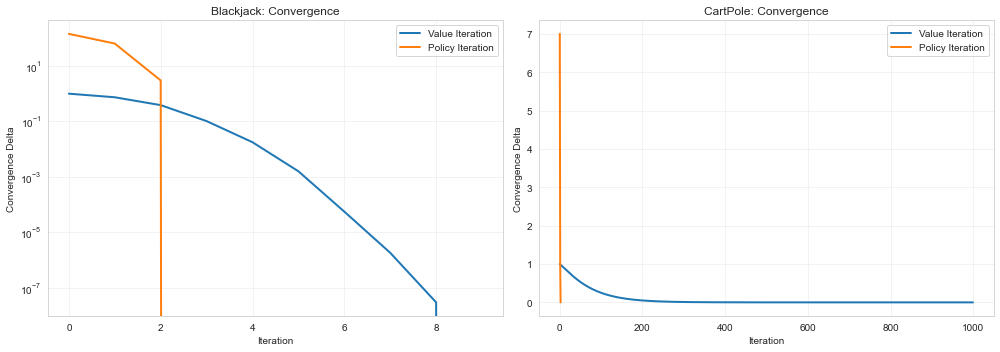

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(conv_bj_vi, label='Value Iteration', linewidth=2)
axes[0].plot(conv_bj_pi, label='Policy Iteration', linewidth=2)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Convergence Delta')
axes[0].set_title('Blackjack: Convergence')
axes[0].set_yscale('log')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(conv_cp_vi_medium, label='Value Iteration', linewidth=2)
axes[1].plot(conv_cp_pi_medium, label='Policy Iteration', linewidth=2)
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Convergence Delta')
axes[1].set_title('CartPole: Convergence')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

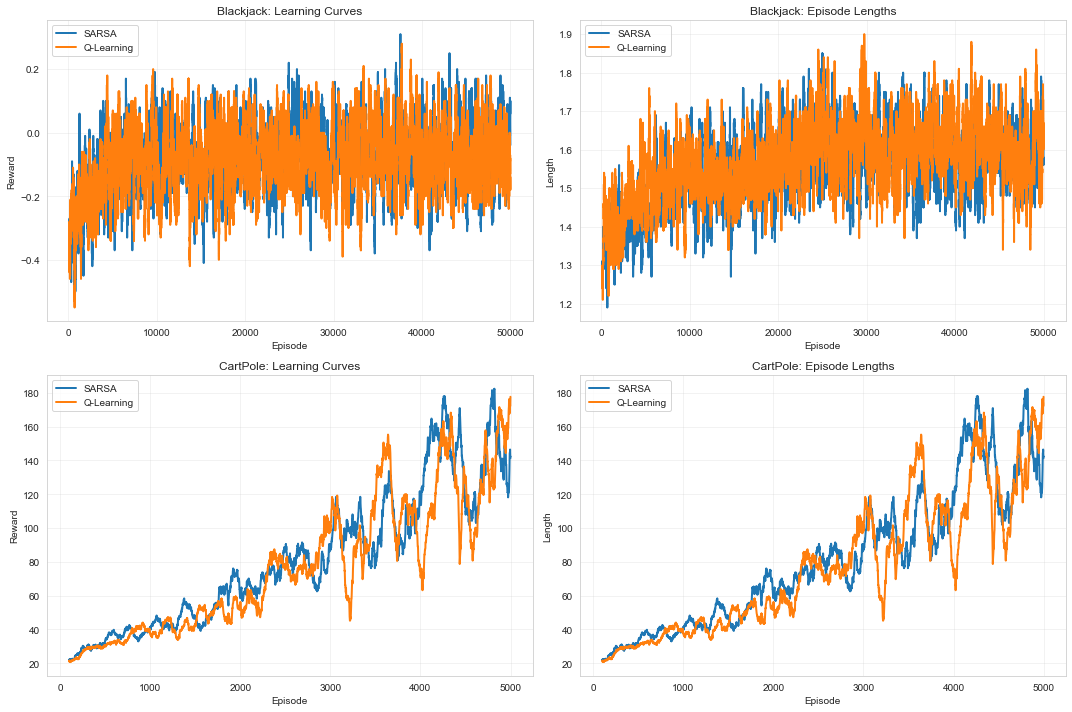

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(pd.Series(rewards_bj_sarsa).rolling(100).mean(), label='SARSA', linewidth=2)
axes[0, 0].plot(pd.Series(rewards_bj_qlearn).rolling(100).mean(), label='Q-Learning', linewidth=2)
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Reward')
axes[0, 0].set_title('Blackjack: Learning Curves')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(pd.Series(lengths_bj_sarsa).rolling(100).mean(), label='SARSA', linewidth=2)
axes[0, 1].plot(pd.Series(lengths_bj_qlearn).rolling(100).mean(), label='Q-Learning', linewidth=2)
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Length')
axes[0, 1].set_title('Blackjack: Episode Lengths')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(pd.Series(rewards_cp_sarsa).rolling(100).mean(), label='SARSA', linewidth=2)
axes[1, 0].plot(pd.Series(rewards_cp_qlearn).rolling(100).mean(), label='Q-Learning', linewidth=2)
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Reward')
axes[1, 0].set_title('CartPole: Learning Curves')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(pd.Series(lengths_cp_sarsa).rolling(100).mean(), label='SARSA', linewidth=2)
axes[1, 1].plot(pd.Series(lengths_cp_qlearn).rolling(100).mean(), label='Q-Learning', linewidth=2)
axes[1, 1].set_xlabel('Episode')
axes[1, 1].set_ylabel('Length')
axes[1, 1].set_title('CartPole: Episode Lengths')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

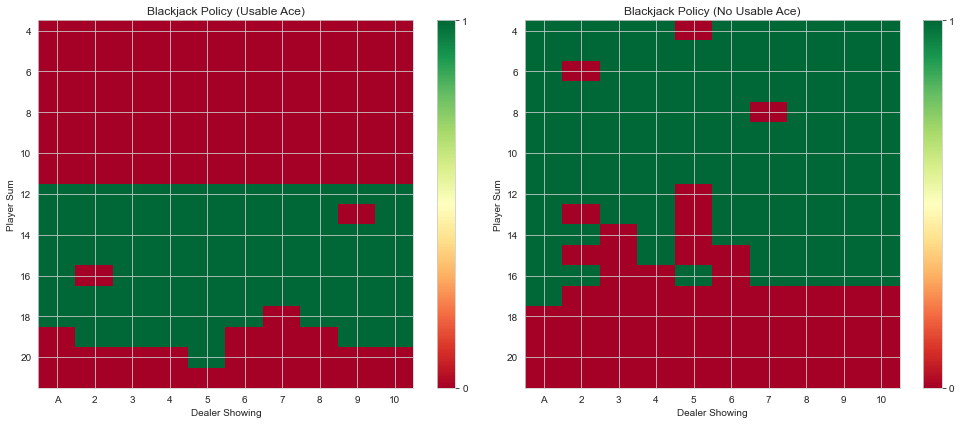

In [22]:
policy_usable = np.zeros((18, 10))
policy_no_usable = np.zeros((18, 10))

for state, action in policy_bj_qlearn.items():
    player_sum, dealer_card, usable_ace = state
    if 4 <= player_sum <= 21 and 1 <= dealer_card <= 10:
        if usable_ace:
            policy_usable[player_sum - 4, dealer_card - 1] = action
        else:
            policy_no_usable[player_sum - 4, dealer_card - 1] = action

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

im1 = axes[0].imshow(policy_usable, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
axes[0].set_xlabel('Dealer Showing')
axes[0].set_ylabel('Player Sum')
axes[0].set_title('Blackjack Policy (Usable Ace)')
axes[0].set_xticks(range(10))
axes[0].set_xticklabels(['A', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
axes[0].set_yticks(range(0, 18, 2))
axes[0].set_yticklabels(range(4, 22, 2))
plt.colorbar(im1, ax=axes[0], ticks=[0, 1])

im2 = axes[1].imshow(policy_no_usable, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
axes[1].set_xlabel('Dealer Showing')
axes[1].set_ylabel('Player Sum')
axes[1].set_title('Blackjack Policy (No Usable Ace)')
axes[1].set_xticks(range(10))
axes[1].set_xticklabels(['A', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
axes[1].set_yticks(range(0, 18, 2))
axes[1].set_yticklabels(range(4, 22, 2))
plt.colorbar(im2, ax=axes[1], ticks=[0, 1])

plt.tight_layout()
plt.show()